In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_parquet('data.parquet', engine='pyarrow')

In [4]:
df = df.between_time(start_time = '09:30:00', end_time = '16:00:00')

In [5]:
df.head()

,banknifty,nifty,tte
time,,,
2021-01-01 09:30:00,0.277355,0.194941,27
2021-01-01 09:31:00,0.275796,0.194808,27
2021-01-01 09:32:00,0.276555,0.194817,27
2021-01-01 09:33:00,0.276262,0.194857,27
2021-01-01 09:34:00,0.277114,0.194556,27


In [6]:
df.tail()

,banknifty,nifty,tte
time,,,
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28
2022-06-30 15:29:00,0.243426,0.216455,28
2022-06-30 15:30:00,0.241907,0.216081,28


In [7]:
df.dropna(inplace = True)

In [8]:
rth = df.between_time(start_time = '09:15:00', end_time = '16:00:00')

In [9]:
rth = rth.drop_duplicates(subset=['nifty'])

In [10]:
rth.head()

,banknifty,nifty,tte
time,,,
2021-01-01 09:30:00,0.277355,0.194941,27
2021-01-01 09:31:00,0.275796,0.194808,27
2021-01-01 09:32:00,0.276555,0.194817,27
2021-01-01 09:33:00,0.276262,0.194857,27
2021-01-01 09:34:00,0.277114,0.194556,27


In [11]:
rth.tail()

,banknifty,nifty,tte
time,,,
2022-06-30 15:23:00,0.239032,0.213391,28
2022-06-30 15:24:00,0.238897,0.213850,28
2022-06-30 15:25:00,0.239237,0.214075,28
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:30:00,0.241907,0.216081,28


In [12]:
part_1 = rth.loc[:'2021-11-30']

In [13]:
part_1.head()

,banknifty,nifty,tte
time,,,
2021-01-01 09:30:00,0.277355,0.194941,27
2021-01-01 09:31:00,0.275796,0.194808,27
2021-01-01 09:32:00,0.276555,0.194817,27
2021-01-01 09:33:00,0.276262,0.194857,27
2021-01-01 09:34:00,0.277114,0.194556,27


In [14]:
part_1.tail()

,banknifty,nifty,tte
time,,,
2021-10-29 15:26:00,0.199172,0.155891,27
2021-10-29 15:27:00,0.198669,0.154814,27
2021-10-29 15:28:00,0.200300,0.155672,27
2021-10-29 15:29:00,0.200082,0.157203,27
2021-10-29 15:30:00,0.200599,0.157080,27


In [15]:
part_2 = rth.loc['2022-01-01':]

In [16]:
part_2.head()

,banknifty,nifty,tte
time,,,
2022-01-03 09:30:00,0.214431,0.153168,24
2022-01-03 09:31:00,0.215009,0.153419,24
2022-01-03 09:32:00,0.214678,0.153120,24
2022-01-03 09:33:00,0.214582,0.152736,24
2022-01-03 09:34:00,0.213579,0.152574,24


In [17]:
part_2.tail()

,banknifty,nifty,tte
time,,,
2022-06-30 15:23:00,0.239032,0.213391,28
2022-06-30 15:24:00,0.238897,0.213850,28
2022-06-30 15:25:00,0.239237,0.214075,28
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:30:00,0.241907,0.216081,28


In [18]:
data = part_1.copy()

In [19]:
S1 = part_1['nifty']
S2 = part_1['banknifty']

In [20]:
score, p_value, _ = coint(S1, S2)
p_value

0.0007328218501292341

p value low therefore cointegration is high

In [21]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

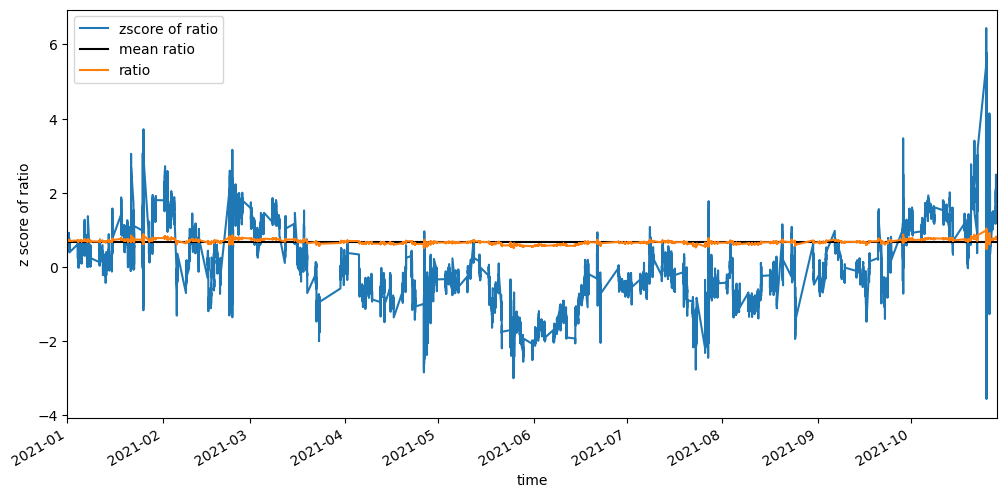

In [22]:
ratio = S1 / S2
zscore(ratio).plot(figsize = (12, 6))
plt.xlim('2021-01-01', '2021-10-29')
plt.axhline(ratio.mean(), color='black')
plt.plot(ratio)
plt.xlabel('time')
plt.ylabel('z score of ratio')
plt.legend(['zscore of ratio', 'mean ratio', 'ratio'])
plt.show()

In [23]:
change = []

In [24]:
def trade(S1, S2, tte):
    window1 = 1800
    window2 = 30
    ratios = S1/S2
    print(ratios)
    ratios.reset_index(drop = True, inplace = True)
    ma1 = ratios.rolling(window=window1, center=False).mean()
    ma2 = ratios.rolling(window=window2, center=False).mean()
    std = ratios.rolling(window=window2, center=False).std()
    zscore = (ma1 - ma2) / std
    # Start with no money and no positions and simulate trading
    money = 0
    profit = 0
    countS1 = 0
    countS2 = 0
    cur = 0
    for i in range(len(ratios)):
        # Buy long if the z-score is < -1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            cur -= S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
        # Sell short if the z-score is > 1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            cur += S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            if cur != 0:
                change.append(S1[i] * countS1 + S2[i] * countS2 - cur)
            cur = 0
            countS1 = 0
            countS2 = 0
    return money

In [25]:
profit1 = trade(part_1['nifty'], part_1['banknifty'], part_1['tte']) 
profit1

time
2021-01-01 09:30:00    0.702854
2021-01-01 09:31:00    0.706349
2021-01-01 09:32:00    0.704442
2021-01-01 09:33:00    0.705335
2021-01-01 09:34:00    0.702079
                         ...   
2021-10-29 15:26:00    0.782700
2021-10-29 15:27:00    0.779254
2021-10-29 15:28:00    0.777192
2021-10-29 15:29:00    0.785691
2021-10-29 15:30:00    0.783050
Length: 62292, dtype: float64


303.05976966989516

In [26]:
profit2 = trade(part_2['nifty'], part_2['banknifty'], part_2['tte']) 
profit2

time
2022-01-03 09:30:00    0.714300
2022-01-03 09:31:00    0.713547
2022-01-03 09:32:00    0.713256
2022-01-03 09:33:00    0.711786
2022-01-03 09:34:00    0.714364
                         ...   
2022-06-30 15:23:00    0.892728
2022-06-30 15:24:00    0.895158
2022-06-30 15:25:00    0.894822
2022-06-30 15:26:00    0.892219
2022-06-30 15:30:00    0.893236
Length: 31610, dtype: float64


174.12852669125868

In [27]:
print('Total profit:', profit1 + profit2)

Total profit: 477.18829636115385


In [28]:
std_po = np.std(change)
print(std_po)

2.8575846850948787


In [29]:
sharpe = (profit1 + profit2) / (std_po * 16)
print('Sharpe Ratio:', sharpe)

Sharpe Ratio: 10.43688002603565
